----
# Tutorial for Evaluating Fairness in Regression

----
## Evaluating Your Own Model? Looking for a Template? 
**Please note: This notebook is intended as an introduction to and reference for evaluating the fairness of a set of machine learning models using FairMLHealth, and it is not designed to work with outside models.**  

We recommend using our [Template-RegressionAssessment](../templates/Template-RegressionAssessment.ipynb) if you are looking for a template into which you can insert existing models. 


## Overview

This notebook introduces concepts, methods, and libraries for measuring fairness in machine learning (ML) models as it relates to problems in healthcare. 

There are abundant other publications covering the theoretical basis for fairness metrics, with many online and academic resources covering the details of specific fairness measures (See [References (bottom)](#references) and [Additional Resources (bottom)](#additional_resources), or [Our Resources Page](../docs/Measures_QuickReference.md)). Many of these excellent references fall short of discussing edge cases as well as the practical and philosophical considerations when evaluating real models for real customers. Here we attempt to bridge this gap.



## Table of Contents
[Part 1](#part1) - Framing the Problem
  
[Part 2](#part2) - Evaluating the Baseline Model

[Part 3](#part3) - Comparing Models 
  
[References](#references)
  


## Requirements

To run this notebook, please install FairMLHealth using [the instructions posted in GitHub](https://github.com/KenSciResearch/fairMLHealth#installation_instructions). Some components of this notebook additionally require the [Fairlearn](https://github.com/fairlearn/fairlearn) package.

The tutorial uses data from the MIMIC III Critical Care database, a freely accessible source of electronic health records from Beth Israel Deaconess Medical Center in Boston. To download the MIMIC III data, please use this link: [Access to MIMIC III](https://mimic.physionet.org/gettingstarted/access/) and save the data with the default directory name ("MIMIC"). No further action is required beyond remembering the download location, and you do not need to unzip any files.

A basic knowledge of ML implementation in Python is assumed. 


----
---- 
# Part 1 - Framing the Problem <a class = "anchor" id = "part1"></a>

In [1]:
# Standard Libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Load Prediction Libraries
import sklearn.metrics as sk_metric
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

# Remove limit to the number of columns and column widths displayed by pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 0) # adjust column width as needed



### Below are helper functions that make the tutorial easier to read

In [2]:
# Helpers from local folder
from fairmlhealth.__mimic_data import load_mimic3_example, feature_table
from fairmlhealth.report import compare
from fairmlhealth import measure, stat_utils


# Verify that all required packages are present
from fairmlhealth.__validation import validate_notebook_requirements
validate_notebook_requirements()

### Loading the MIMIC III Data Subset <a id="datasubset"></a>

As mentioned above, the MIMIC-III data download contains a folder of zipped_files. The tutorial code in the [Data Subset](#datasubset) section below will automatically unzip and format all necessary data for these experiments, saving the formatted data in the same MIMIC folder. Simply enter the correct path of the MIMIC folder in the following cell to enable this feature. Your path should end with the directory "MIMIC".

Example: path_to_mimic_data_folder = "~/data/MIMIC"

In [3]:
# path_to_mimic_data_folder = "[path to your downloaded data folder]"
path_to_mimic_data_folder = "~/data/MIMIC"

Example models in this notebook use data from all years of the MIMIC-III dataset for patients aged 65 and older. Data are imported at the encounter level with all additional patient identification dropped. All models include an "AGE" feature, simplified to 5-year bins, as well as Boolean diagnosis and procedure features categorized through the Clinical Classifications Software system ([HCUP](https://www.hcup-us.ahrq.gov/toolssoftware/ccs/ccs.jsp)). All features other than age are one-hot encoded and prefixed with their variable type (e.g. "GENDER_", "ETHNICITY_").  

In [4]:
# Load data and keep a 10K observation subset to speed processing
df = load_mimic3_example(path_to_mimic_data_folder) 
df = df.sample(n=10000, random_state=32).reset_index(drop=True)

# Subset to ages 65+
df = df.loc[df['AGE'].ge(65), :]
df.drop('GENDER_F', axis=1, inplace=True) # Redundant with GENDER_M

# Display insights
display(feature_table(df))
print("\n\n", "Below is a scrollable version of the first five rows of data:")
display(df.head())


 This data subset has 4704 total observations and 648 input features 



,Raw Feature,Category Count (Encoded Features).
0,AGE,1
1,DIAGNOSIS,282
2,ETHNICITY,41
3,GENDER,1
4,INSURANCE,5
5,LANGUAGE,69
6,MARRIED,7
7,PROCEDURE,222
8,RELIGION,20




 Below is a scrollable version of the first five rows of data:


,ADMIT_ID,AGE,GENDER_M,ETHNICITY_AMERICAN INDIAN/ALASKA NATIVE,ETHNICITY_AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGNIZED TRIBE,ETHNICITY_ASIAN,ETHNICITY_ASIAN - ASIAN INDIAN,ETHNICITY_ASIAN - CAMBODIAN,ETHNICITY_ASIAN - CHINESE,ETHNICITY_ASIAN - FILIPINO,ETHNICITY_ASIAN - JAPANESE,ETHNICITY_ASIAN - KOREAN,ETHNICITY_ASIAN - OTHER,ETHNICITY_ASIAN - THAI,ETHNICITY_ASIAN - VIETNAMESE,ETHNICITY_BLACK/AFRICAN,ETHNICITY_BLACK/AFRICAN AMERICAN,ETHNICITY_BLACK/CAPE VERDEAN,ETHNICITY_BLACK/HAITIAN,ETHNICITY_CARIBBEAN ISLAND,ETHNICITY_HISPANIC OR LATINO,ETHNICITY_HISPANIC/LATINO - CENTRAL AMERICAN (OTHER),ETHNICITY_HISPANIC/LATINO - COLOMBIAN,ETHNICITY_HISPANIC/LATINO - CUBAN,ETHNICITY_HISPANIC/LATINO - DOMINICAN,ETHNICITY_HISPANIC/LATINO - GUATEMALAN,ETHNICITY_HISPANIC/LATINO - HONDURAN,ETHNICITY_HISPANIC/LATINO - MEXICAN,ETHNICITY_HISPANIC/LATINO - PUERTO RICAN,ETHNICITY_HISPANIC/LATINO - SALVADORAN,ETHNICITY_MIDDLE EASTERN,ETHNICITY_MULTI RACE ETHNICITY,ETHNICITY_NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER,ETHNICITY_OTHER,ETHNICITY_PATIENT DECLINED TO ANSWER,ETHNICITY_PORTUGUESE,ETHNICITY_SOUTH AMERICAN,ETHNICITY_UNABLE TO OBTAIN,ETHNICITY_UNKNOWN/NOT SPECIFIED,ETHNICITY_WHITE,ETHNICITY_WHITE - BRAZILIAN,ETHNICITY_WHITE - EASTERN EUROPEAN,ETHNICITY_WHITE - OTHER EUROPEAN,ETHNICITY_WHITE - RUSSIAN,LANGUAGE_* BE,LANGUAGE_* FU,LANGUAGE_** T,LANGUAGE_**SH,LANGUAGE_**TO,LANGUAGE_*AMH,LANGUAGE_*ARA,LANGUAGE_*ARM,LANGUAGE_*BEN,LANGUAGE_*BOS,LANGUAGE_*BUL,LANGUAGE_*BUR,LANGUAGE_*CAN,LANGUAGE_*CDI,LANGUAGE_*CHI,LANGUAGE_*DEA,LANGUAGE_*DUT,LANGUAGE_*FAR,LANGUAGE_*FIL,LANGUAGE_*FUL,LANGUAGE_*GUJ,LANGUAGE_*HUN,LANGUAGE_*IBO,LANGUAGE_*KHM,LANGUAGE_*LEB,LANGUAGE_*MAN,LANGUAGE_*MOR,LANGUAGE_*NEP,LANGUAGE_*PER,LANGUAGE_*PHI,LANGUAGE_*PUN,LANGUAGE_*SPA,LANGUAGE_*TAM,LANGUAGE_*TOI,LANGUAGE_*TOY,LANGUAGE_*URD,LANGUAGE_*YID,LANGUAGE_*YOR,LANGUAGE_ALBA,LANGUAGE_AMER,LANGUAGE_ARAB,LANGUAGE_BENG,LANGUAGE_CAMB,LANGUAGE_CANT,LANGUAGE_CAPE,LANGUAGE_ENGL,LANGUAGE_ETHI,LANGUAGE_FREN,LANGUAGE_GREE,LANGUAGE_HAIT,LANGUAGE_HIND,LANGUAGE_ITAL,LANGUAGE_JAPA,LANGUAGE_KORE,LANGUAGE_LAOT,LANGUAGE_MAND,LANGUAGE_PERS,LANGUAGE_POLI,LANGUAGE_PORT,LANGUAGE_PTUN,LANGUAGE_RUSS,LANGUAGE_SERB,LANGUAGE_SOMA,LANGUAGE_SPAN,LANGUAGE_TAGA,LANGUAGE_THAI,LANGUAGE_TURK,LANGUAGE_URDU,LANGUAGE_VIET,INSURANCE_Government,INSURANCE_Medicaid,INSURANCE_Medicare,INSURANCE_Private,INSURANCE_Self Pay,MARRIED_DIVORCED,MARRIED_LIFE PARTNER,MARRIED_MARRIED,MARRIED_SEPARATED,MARRIED_SINGLE,MARRIED_UNKNOWN (DEFAULT),MARRIED_WIDOWED,RELIGION_7TH DAY ADVENTIST,RELIGION_BAPTIST,RELIGION_BUDDHIST,RELIGION_CATHOLIC,RELIGION_CHRISTIAN SCIENTIST,RELIGION_EPISCOPALIAN,RELIGION_GREEK ORTHODOX,RELIGION_HEBREW,RELIGION_HINDU,RELIGION_JEHOVAH'S WITNESS,RELIGION_JEWISH,RELIGION_LUTHERAN,RELIGION_METHODIST,RELIGION_MUSLIM,RELIGION_NOT SPECIFIED,RELIGION_OTHER,RELIGION_PROTESTANT QUAKER,RELIGION_ROMANIAN EAST. ORTH,RELIGION_UNITARIAN-UNIVERSALIST,RELIGION_UNOBTAINABLE,DIAGNOSIS_CCS_0,DIAGNOSIS_CCS_1,DIAGNOSIS_CCS_2,DIAGNOSIS_CCS_3,DIAGNOSIS_CCS_4,DIAGNOSIS_CCS_5,DIAGNOSIS_CCS_6,DIAGNOSIS_CCS_7,DIAGNOSIS_CCS_8,DIAGNOSIS_CCS_9,DIAGNOSIS_CCS_10,DIAGNOSIS_CCS_11,DIAGNOSIS_CCS_12,DIAGNOSIS_CCS_13,DIAGNOSIS_CCS_14,DIAGNOSIS_CCS_15,DIAGNOSIS_CCS_16,DIAGNOSIS_CCS_17,DIAGNOSIS_CCS_18,DIAGNOSIS_CCS_19,DIAGNOSIS_CCS_20,DIAGNOSIS_CCS_21,DIAGNOSIS_CCS_22,DIAGNOSIS_CCS_23,DIAGNOSIS_CCS_24,DIAGNOSIS_CCS_25,DIAGNOSIS_CCS_26,DIAGNOSIS_CCS_27,DIAGNOSIS_CCS_28,DIAGNOSIS_CCS_29,DIAGNOSIS_CCS_30,DIAGNOSIS_CCS_31,DIAGNOSIS_CCS_32,DIAGNOSIS_CCS_33,DIAGNOSIS_CCS_34,DIAGNOSIS_CCS_35,DIAGNOSIS_CCS_36,DIAGNOSIS_CCS_37,DIAGNOSIS_CCS_38,DIAGNOSIS_CCS_39,DIAGNOSIS_CCS_40,DIAGNOSIS_CCS_41,DIAGNOSIS_CCS_42,DIAGNOSIS_CCS_43,DIAGNOSIS_CCS_44,DIAGNOSIS_CCS_45,DIAGNOSIS_CCS_46,DIAGNOSIS_CCS_47,DIAGNOSIS_CCS_48,DIAGNOSIS_CCS_49,DIAGNOSIS_CCS_50,DIAGNOSIS_CCS_51,DIAGNOSIS_CCS_52,DIAGNOSIS_CCS_53,DIAGNOSIS_CCS_54,DIAGNOSIS_CCS_55,DIAGNOSIS_CCS_56,DIAGNOSIS_CCS_57,DIAGNOSIS_CCS_58,DIAGNOSIS_CCS_59,DIAGNOSIS_CCS_60,DIAGNOSIS_CCS_61,DIAGNOSIS_CCS_62,DIAGNOS

### Generating the Model <a id="generatemodel"></a>


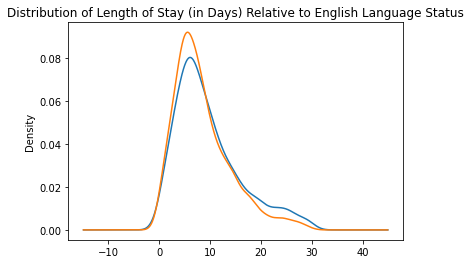

In [5]:
# Display LOS Distributions
ax = df.groupby('LANGUAGE_ENGL')['length_of_stay'
        ].plot(kind='kde', 
               title="Distribution of Length of Stay (in Days) Relative to English Language Status")
plt.show()

In [6]:
# Subset Data
baseline_cols = [c for c in df.columns if (c.startswith('AGE') or c.startswith('DIAGNOSIS_') or c.startswith('PROCEDURE_') or c == "LANGUAGE_ENGL")]
X = df.loc[:, baseline_cols]
y = df['length_of_stay'].clip(0, 25)

# Split Data
splits = train_test_split(X, y, test_size=0.33, random_state=42)
X_train, X_test, y_train, y_test = splits

In [7]:
# Train New Model with Language Feature
baseline_model = LinearRegression()
baseline_model.fit(X_train, y_train)
y_pred = baseline_model.predict(X_test)
print("Max Y before bounding:", np.max(y_pred))


# Since the regression is unbounded, clip all values greater than 25 
class bounded_baseline(object):
    def predict(X):
        return np.clip(baseline_model.predict(X), 0, 25)

y_pred = bounded_baseline.predict(X_test)
print("Max Y after bounding:", np.max(y_pred))

Max Y before bounding: 2938873593794.152
Max Y after bounding: 25.0


### FairMLHealth Stratified Data Table

FairMLHealth includes stratified table features to aid in identifying the source of unfairness or other bias. The data table can be used to compare basic statistics specific to each feature-value, in addition to relative statistics for the target value. Since many features can be evaluated at once, it can be a useful option for identifying patterns of bias either alone or in concert with other methods (e.g., visualization).

Our experiment tests sociodemographic bias as it relates to language and age. Language may also be used as a proxy for race, religion, or nationality, which are [explicitly protected attributes](https://www.eeoc.gov/employers/small-business/3-who-protected-employment-discrimination). 

In this example, we can see that there are similar sample sizes (within 6%) for the English speaking and Non-English speaking groups, where the mean length of stay for Non-English speakers is 10 days (vs 8.7 days for English speakers). Similarly, for age, most groups have a similar number of members with the exceptions of the 85 y.o. and 90 y.o. groups.

In [8]:
print("FairMLHealth Stratified Data Table")
measure.data(X_test, y_test, features=['LANGUAGE_ENGL', 'AGE'])

FairMLHealth Stratified Data Table


,Feature Name,Feature Value,Obs.,Entropy,Mean length_of_stay,Median length_of_stay,Missing Values,Std. Dev. length_of_stay,Value Prevalence
0,ALL FEATURES,ALL VALUES,1553,NaN,8.9944,7.6708,0,5.8920,1.0000
1,LANGUAGE_ENGL,0.0,727,0.9971,9.6945,8.3229,0,6.2507,0.4681
2,LANGUAGE_ENGL,1.0,826,0.9971,8.3782,7.2438,0,5.4876,0.5319
3,AGE,65.0,314,2.4445,8.6585,7.1024,0,5.8617,0.2022
4,AGE,70.0,312,2.4445,9.4667,7.9226,0,6.2212,0.2009
5,AGE,75.0,321,2.4445,8.8027,7.3222,0,5.7801,0.2067
6,AGE,80.0,334,2.4445,9.0683,7.7760,0,5.7986,0.2151
7,AGE,85.0,218,2.4445,9.0675,8.2378,0,5.8299,0.1404
8,AGE,90.0,54,2.4445,8.6052,7.5674,0,5.6591,0.0348


### FairMLHealth Stratified Performance Table

The stratified performance table compares model performance specific to each feature-value subset. In this example, we can see that the MAE for the Non-English speaking group is higher than that of the English-speaking group.

In [9]:
print("FairMLHealth Stratified Performance Table")
measure.performance(X_test, y_test, y_pred, features=['LANGUAGE_ENGL', 'AGE'], pred_type="regression")

FairMLHealth Stratified Performance Table


,Feature Name,Feature Value,Obs.,Mean Target,Mean Prediction,MAE,MSE,Mean Error,Rsqrd,Std. Dev. Error,Std. Dev. Prediction,Std. Dev. Target
0,ALL FEATURES,ALL VALUES,1553.0,8.9944,9.0511,3.4197,20.7115,0.0567,0.4030,4.5521,4.7124,5.8920
1,LANGUAGE_ENGL,0,727.0,9.6945,9.7170,3.6416,22.4746,0.0225,0.4240,4.7439,4.5198,6.2507
2,LANGUAGE_ENGL,1,826.0,8.3782,8.4650,3.2244,19.1597,0.0868,0.3630,4.3790,4.8024,5.4876
3,AGE,65,314.0,8.6585,8.4925,3.3119,19.2778,-0.1660,0.4371,4.3945,4.4046,5.8617
4,AGE,70,312.0,9.4667,8.9928,3.5428,21.9925,-0.4739,0.4299,4.6731,4.7110,6.2212
5,AGE,75,321.0,8.8027,8.9252,3.2380,18.6499,0.1225,0.4400,4.3235,4.5301,5.7801
6,AGE,80,334.0,9.0683,9.3139,3.4800,22.3378,0.2455,0.3337,4.7270,4.9265,5.7986
7,AGE,85,218.0,9.0675,9.6680,3.6815,23.3221,0.6005,0.3107,4.8028,5.0624,5.8299
8,AGE,90,54.0,8.6052,9.2683,2.9872,13.3041,0.6631,0.5767,3.6204,4.4868,5.6591


### FairMLHealth Stratified Bias Table

The stratified bias table contains prediction bias measures specific to each feature-value subset. It assumes each feature-value as the "privileged" group relative to all other possible values for the feature. 

For this example, let's assume conservative "fair" boundaries for our error. Since the default boundaries for MAE difference are 10% of the range of absolute error, we define a more conservative custom boundary of +/- 10% of the MAE. Similarly, for the MAE Ratio, we set is as 1 +/- 10%. 

In [10]:
# The default boundaries for MAE difference are 10% of the range of absolute error. For this example,
#    we've set it to a more conservative custom boundary of +/- 10% of the MAE
mae = sk_metric.mean_absolute_error(y_test, y_pred)
max_diff = 0.1*mae
custom_fair_range = {'MAE Difference':(-max_diff, max_diff), 'MAE Ratio':(0.9, 1.1)}

In [11]:
print("FairMLHealth Stratified Bias Table")

# Note that flag_oor is set to False by default for this feature
measure.bias(X_test, 
             y_test, 
             y_pred, 
             features=['LANGUAGE_ENGL', 'AGE'], 
             pred_type="regression",
             flag_oor=True, 
             custom_ranges=custom_fair_range
            )

FairMLHealth Stratified Bias Table


,Feature Name,Feature Value,MAE Difference,MAE Ratio,Mean Prediction Difference,Mean Prediction Ratio
0,LANGUAGE_ENGL,0,-0.4172,0.8854,-1.2520,0.8712
1,LANGUAGE_ENGL,1,0.4172,1.1294,1.2520,1.1479
2,AGE,65.0,0.1352,1.0408,0.7002,1.0824
3,AGE,70.0,-0.1539,0.9565,0.0729,1.0081
4,AGE,75.0,0.2291,1.0708,0.1587,1.0178
5,AGE,80.0,-0.0767,0.9779,-0.3348,0.9641
6,AGE,85.0,-0.3045,0.9173,-0.7177,0.9258
7,AGE,90.0,0.4481,1.1500,-0.2250,0.9757


We may also want to evaluate the intersectional fairness of our model relative to both attributes at once. We can see that differences in language hold across most age groups, and are particularly pronounced in the oldest two groups.

In [12]:
measure.bias(X_test, 
             y_test, 
             y_pred, 
             features=['LANGUAGE_ENGL'], 
             pred_type="regression",
             flag_oor=True, 
             custom_ranges=custom_fair_range,
             add_overview=False,
             cohort_labels=X_test['AGE'].astype(int)
            )

,AGE,Feature Name,Feature Value,MAE Difference,MAE Ratio,Mean Prediction Difference,Mean Prediction Ratio
0,65,LANGUAGE_ENGL,0,0.3521,1.1136,-0.4037,0.9538
1,65,LANGUAGE_ENGL,1,-0.3521,0.8980,0.4037,1.0485
2,70,LANGUAGE_ENGL,0,-0.9153,0.7739,-1.1664,0.8789
3,70,LANGUAGE_ENGL,1,0.9153,1.2922,1.1664,1.1377
4,75,LANGUAGE_ENGL,0,-0.8936,0.7572,-1.6436,0.8312
5,75,LANGUAGE_ENGL,1,0.8936,1.3206,1.6436,1.2030
6,80,LANGUAGE_ENGL,0,-0.1178,0.9667,-0.6689,0.9307
7,80,LANGUAGE_ENGL,1,0.1178,1.0344,0.6689,1.0744
8,85,LANGUAGE_ENGL,0,-0.4160,0.8929,-2.1880,0.7961
9,85,LANGUAGE_ENGL,1,0.4160,1.1200,2.1880,1.2561


### Significance Testing

It is generally recommended to test whether any differences in model outcomes for protected attributes are the effect of a sampling error in our test. FairMLHealth comes with a bootstrapping utility and supporting functions that can be used in statistical testing. The bootstrapping feature accepts any function that returns a p-value and will return a True or False if the p-value is greater than some alpha for a threshold number of randomly sampled trials. Three examples using the bootstrap_significance tool with built-in test functions are shown below. The first and second tests indicate that there is likely a statistically significant difference in the of length of stay between English speakers and Non-English speakers. The third and fourth test indicate no likely significant difference either in the predicted distributions or in the distributions of prediction error, even when using a conservative threshold of 50% (i.e., at least 50% of trials must have a p-value less than alpha to indicate a difference). However, these tests are not comprehensive. For the purposes of the tutorial, we'll proceed as though we're convinced of a statistical difference.


In [13]:
speaks_engl = df['LANGUAGE_ENGL'].eq(1)

# Krusakal-Wallis (K-W) to test the likelihood of statistical difference in the mean LOS
# relative to recorded English-speaking ability in the input data
pval = stat_utils.kruskal_pval(a=df.loc[speaks_engl, 'length_of_stay'], 
                               b=df.loc[~speaks_engl, 'length_of_stay'], 
                               # If n_sample set to None, tests on full dataset rather than sample
                               n_sample=None 
                              )
print("P-Value of single K-W test:", pval)

# Bootstrapped K-W test for the same data
alpha = 0.05
reject_h0 = stat_utils.bootstrap_significance(func=stat_utils.kruskal_pval, 
                                              a=y.loc[speaks_engl], 
                                              b=y.loc[~speaks_engl],
                                              alpha=alpha,
                                              n_trials=100)
print(f"Was the p-value less than alpha in at least 1-alpha ({1-alpha}) proportion of trials?", reject_h0)

P-Value of single K-W test: 1.2185913167536026e-07
Was the p-value less than alpha in at least 1-alpha (0.95) proportion of trials? True


In [14]:
# Bootstrapped K-W Test for true values
test_speaks_engl = X_test['LANGUAGE_ENGL'].eq(1)
reject_h0 = stat_utils.bootstrap_significance(func=stat_utils.kruskal_pval, 
                                              a=y_test.loc[test_speaks_engl], 
                                              b=y_test.loc[~test_speaks_engl],
                                              alpha=0.05,
                                              n_trials=1000)
print("Can we reject the null hypothesis that targets are from the same distribution?\n", reject_h0)

Can we reject the null hypothesis that targets are from the same distribution?
 True


In [15]:
# Bootstrapped K-W Test for predictions
reject_h0 = stat_utils.bootstrap_significance(func=stat_utils.kruskal_pval, 
                                              a=np.ma.masked_array(y_pred, test_speaks_engl), 
                                              b=np.ma.masked_array(y_pred, ~test_speaks_engl),
                                              alpha=0.05,
                                              threshold=0.5,
                                              n_trials=100)
print("Can we reject the null hypothesis that prediction results are from the same distribution?\n", reject_h0)

Can we reject the null hypothesis that prediction results are from the same distribution?
 False


In [16]:
# Bootstrapped K-W Test for prediction error
reject_h0 = stat_utils.bootstrap_significance(func=stat_utils.kruskal_pval, 
                                              a=np.ma.masked_array(y_pred-y_test, test_speaks_engl), 
                                              b=np.ma.masked_array(y_pred-y_test, ~test_speaks_engl),
                                              alpha=0.05,
                                              threshold=0.5,
                                              n_trials=100)
print("Can we reject the null hypothesis that prediction errors are from the same distribution for language?\n", reject_h0)

Can we reject the null hypothesis that prediction errors are from the same distribution for language?
 False


In [17]:
# Bootstrapped K-W Test for prediction error
test_is90plus = X_test['AGE'].eq(90).astype(int)
reject_h0 = stat_utils.bootstrap_significance(func=stat_utils.kruskal_pval, 
                                              a=np.ma.masked_array(y_pred-y_test, test_is90plus), 
                                              b=np.ma.masked_array(y_pred-y_test, ~test_is90plus),
                                              alpha=0.05,
                                              threshold=0.5,
                                              n_trials=100)
print("Can we reject the null hypothesis that prediction errors are from the same distribution for age?\n", reject_h0)

Can we reject the null hypothesis that prediction errors are from the same distribution for age?
 False


----
----
# Part 2 - Comparing Measures <a id="part2"></a>

In the scenario where a statistical difference was found relative to language or relative to age 90+, we may want to report our findings to our team or to our stakeholders. Using fairMLHealth we can create a custom report comparing key indicators by passing integer tags for our protected attributes.

Using our previously defined boundaries, we can see that the error in our test model is outside of what we've defined as an acceptable rage.


In [18]:
print("FairMLHealth Fairness Measure Report: English Language")
compare(test_data = X_test, 
        targets = y_test, 
        protected_attr = {'English Language': X_test['LANGUAGE_ENGL'], 
                          'Age 90+': X_test['AGE'].eq(90).astype(int)}, 
        models = bounded_baseline, 
        pred_type = "regression",
        custom_ranges = custom_fair_range
       )

FairMLHealth Fairness Measure Report: English Language


# Special Cases

For many regression problems, the effect of the error may differ depending upon the result. To use a hypothetical example, suppose that those patients for whom the length of ICU stay will be greater than 10 hours are better served by special longer-term unit. Those paients whose length of stay is predicted to be longer than 12 hours are automatically transferred to this special unit. However, cases for which the predictions are between 4 and 12 hours are reviewed on a case-by-case basis where proximity and direction to the 8-hour threshol heavily weighted factors in the decision. Since the mean length of stay in our dataset is 9 hours, the prediction error will be  critical for patients with middling values. In these cases it can be useful to evaluate the model relative to each prediction cohort. For the example plots below, data are divided into three groups as shown in the table below.


| Predicted LOS (Time Group) | Action |
|- |- |
|0 - 6 hrs | No Action |
|6 - 12 hrs | Flagged for Review; Possible Transfer to Special Unit |
|12+ hrs | Automatic Transfer to Special Unit |

In [19]:
# Generate cohorts
cohorts = pd.Series(np.zeros(len(y_test)), index=y_test.index, name="Time Group")
cohorts.loc[y_test.ge(6) & y_test.lt(12)] = 1
cohorts.loc[y_test.ge(12)]  = 2
cohorts = cohorts.map({0:"0-6 hrs", 1:"6-12 hrs", 2:"12+ hrs"})

# Append cohorts to data
cohort_data = pd.concat([cohorts, y_test.rename('Length of Stay')], axis=1)
cohort_data['Error'] = y_pred-y_test

As we can observe in the table and figure below, the mean error for each group leans in the direction of the population mean, which was shown above to be approximately 9 hours. The model is over-predicting for the 0-6 hour time group and under-predicting for the 12+ hour time group, but errors appear to be small enough that predictions remain within their relative groups.

In [20]:
cohort_data.groupby('Time Group')[['Length of Stay', 'Error']].mean()

,Length of Stay,Error
Time Group,,
0-6 hrs,3.639920,2.715982
12+ hrs,17.549831,-4.038774
6-12 hrs,8.635863,0.139941


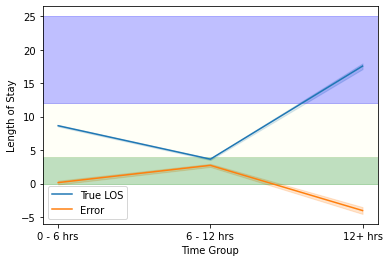

In [21]:
# Generate plots
g = sns.lineplot(x=cohorts, y=y_test)
sns.lineplot(x=cohorts, y=pd.Series(y_pred-y_test, name="Error")) # Adds line for the error
g.axhspan(0, 4, alpha=0.25, color='green') 
g.axhspan(4, 12, alpha=0.25, color='lightyellow')
g.axhspan(12, 25, alpha=0.25, color='blue')
plt.xticks([*range(3)], labels=["0 - 6 hrs", "6 - 12 hrs", "12+ hrs"])

g.set_ylabel("Length of Stay")
plt.legend(labels=["True LOS", "Error"])
plt.show()

Using the bias table, we can verify that any between-group differences in the observed error are within the fair range for each group.

In [22]:
measure.bias(X_test, 
             y_test, 
             y_pred, 
             features=['LANGUAGE_ENGL'], 
             pred_type="regression",
             cohort_labels=cohorts,
             add_overview=False,
             flag_oor=False
            )

,Feature Name,Feature Value,MAE Difference,MAE Ratio,Mean Prediction Difference,Mean Prediction Ratio
Time Group,,,,,,
0-6 hrs,LANGUAGE_ENGL,0,-0.9859,0.7271,-1.2907,0.8185
0-6 hrs,LANGUAGE_ENGL,1,0.9859,1.3754,1.2907,1.2217
12+ hrs,LANGUAGE_ENGL,0,-0.1973,0.9630,-0.1423,0.9895
12+ hrs,LANGUAGE_ENGL,1,0.1973,1.0384,0.1423,1.0106
6-12 hrs,LANGUAGE_ENGL,0,0.3116,1.1253,-0.6368,0.9301
6-12 hrs,LANGUAGE_ENGL,1,-0.3116,0.8887,0.6368,1.0752


----
----
# References

## Citations
<a id="Agarwal2019"></a>
Agarwal, A., Dudik, M., & Wu, Z.S. (2019, May). Fair regression: Quantitative definitions and reduction-based algorithms. In International Conference on Machine Learning (pp. 120-129). PMLR. Available through https://arxiv.org/pdf/1905.12843.pdf

Bellamy, R.K., Dey, K., Hind, M., Hoffman, S.C., Houde, S., Kannan, K., ... & Nagar S (2018). AI Fairness 360: An extensible toolkit for detecting, understanding, and mitigating unwanted algorithmic bias. arXiv Preprint. [arXiv:1810.01943.](https://arxiv.org/abs/1810.01943). See Also [AIF360 Documentation](http://aif360.mybluemix.net/) 

Berk, R., Heidari, H., Jabbari, S., Joseph, M., Kearns, M., Morgenstern, J., Neel, S. and Roth, A., 2017. A convex framework for fair regression. arXiv preprint retrieved from [https://arxiv.org/pdf/1706.02409](https://arxiv.org/pdf/1706.02409)

<a id="fourfifths_ref"></a>
Equal Employment Opportunity Commission, & Civil Service Commission, Department of Labor & Department of Justice (1978). Uniform guidelines on employee selection procedures. Federal Register, 43(166), 38290-38315. Retrieved from [http://uniformguidelines.com/uniformguidelines.html#18](http://uniformguidelines.com/uniformguidelines.html#18) 

Steinberg, D., Reid, A., & O'Callaghan, S. (2020). Fairness Measures for Regression via Probabilistic Classification. arXiv preprint retrieved from [https://arxiv.org/pdf/2001.06089](https://arxiv.org/pdf/2001.06089])

Verma, S. and Rubin, J., 2018, May. Fairness definitions explained. In 2018 ieee/acm international workshop on software fairness (fairware) (pp. 1-7). IEEE. doi: [10.1145/3194770.3194776](https://dl.acm.org/doi/10.1145/3194770.3194776)

## Other Resources
[fairMLHealth Documentation and Resources](../docs/resources)
* [Evaluating Fairness](../docs/resources/Evaluating_Fairness.md)
* [Quick Reference Tables](../docs/resources/Measures_QuickReference.md)
* [Full List of Outside References and Resources](../docs/resources/References_and_Resources.md)
